In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.integrate import simps
from scipy.optimize import brentq

import sys
import dill

from functools import partial
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

In [3]:
from matplotlib.ticker import FuncFormatter

In [4]:
def formatter_tex_time(x, pos):
    if x == 0.:
        return r'$\rm{0 \, y}$'
    
    str_x = str(x)
    
    if str_x[-1] == '0':
        return r'$\rm{%s \, y}$' % (str_x[:-2])

    return r'$\rm{%s \, y}$' % (str_x)

formatter_tex_time = FuncFormatter(formatter_tex_time)

In [5]:
def formatter_tex_time(x, pos):
    if x == 0.:
        return r'$\rm{0}$'
    
    str_x = str(x)
    
    if str_x[-1] == '0':
        return r'$\rm{%s}$' % (str_x[:-2])

    return r'$\rm{%s}$' % (str_x)

formatter_tex_time = FuncFormatter(formatter_tex_time)

In [6]:
labelsize = 18
titlesize = 20

In [7]:
sys.path.append('..')

In [8]:
from finance.discountfactor import ConstantRateDiscountFactor
from finance.products.european.swap import SwapContract
from utils import time_offseter

loaded_data = None

with open('precomputed_sims/data1.pkl', 'rb') as f:
    loaded_data = dill.load(f)
    
step = 1 / 360.
delta = 5 * step

maturity = 5.0
print "Maturity = %s years" % maturity

R = 0.02
H = 0.1
discount = ConstantRateDiscountFactor(R)

udlyings = loaded_data["underlyings"]
print "Maximum number of paths: %i" % len(udlyings)

GBM0 = udlyings[0]
kappa = GBM0.drifts[0][0]
sigma = GBM0.vols[0][0]
print "kappa = %s, sigma = %s" % (kappa, sigma)

time_grid = GBM0.time

derivatives_nb = 1

swap_delta = 0.25
swap_dates = SwapContract.generate_payment_dates(0, maturity, swap_delta)
swap = SwapContract(GBM0, discount, swap_dates)

print swap

p_fixed = 1.
strike = swap.strike

delta_times = swap.delta_time
discount_factors = [discount(t) for t in swap.pillars[1:]]

delta_beta_sum = np.dot(delta_times, discount_factors)

notional = p_fixed / (strike * delta_beta_sum)

print "Notional on the swap: %s" % notional

copula = loaded_data["credit"]["copula"]
c_subsets_indexes = loaded_data["credit"]["bc_subsets_indexes"]
obligors_nb = len(copula.subsets[c_subsets_indexes[-1]][0])
print "Obligor numbers: %s" % obligors_nb

c_ids = [17, 9, 29, 26, 50, 4, 5, 13, 64]
c_positions = [0.69, -0.46, -0.44, -0.36, 0.34, 0.23, 0.09, -0.05, -0.04]

print "Counterparties id: %s (nb = %s)" % (c_ids, len(c_ids))

POSITIONS = np.zeros(obligors_nb)
for idx, ps in zip(c_ids, c_positions):
    POSITIONS[idx] = ps

POSITIONS = POSITIONS / -POSITIONS[13]
POSITIONS = np.array(POSITIONS).flatten()

print POSITIONS

spreads = [176, 45, 367, 1053, 73, 56, 52, 61, 108]
IDS_SPREADS = dict((id_, spread_) for (id_, spread_) in zip(c_ids, spreads))
IDS_POSITIONS = dict((id_, pos_) for (id_, pos_) in zip(c_ids, c_positions))

Maturity = 5.0 years
Maximum number of paths: 20000
kappa = 0.12, sigma = 0.2
Swap contract of maturity T = 5 years, over S^0 with strike K = 134.306, paying at {0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50, 4.75, 5.00}
Notional on the swap: 0.0015687485053
Obligor numbers: 125
Counterparties id: [17, 9, 29, 26, 50, 4, 5, 13, 64] (nb = 9)
[  0.    0.    0.    0.    4.6   1.8   0.    0.    0.   -9.2   0.    0.
   0.   -1.    0.    0.    0.   13.8   0.    0.    0.    0.    0.    0.
   0.    0.   -7.2   0.    0.   -8.8   0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    6.8   0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.   -0.8   0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    

In [9]:
QUANTIME_IM = 0.85
QUANTILE_ES = 0.99

LOIM_PATH = './res/aggregated/loss_over_im'
CVA_PATH = './res/aggregated/cva_ccp'

times_cva = np.arange(0, maturity, 0.5)

shifted_times_cva = times_cva + 1.
shifted_times_cva[-1] = maturity

In [10]:
def fact_(swap_, discount_, kappa_, delta_, t_):
    time_grid_ = swap_.underlying.time
    t_delta_ = time_offseter(t_ + delta_, time_grid_, True)
    
    coupon_dates_ = swap_.pillars
    l_t_delta_ = np.searchsorted(coupon_dates_, t_delta_, side='left')

    beta_T_l_ = map(discount_, coupon_dates_[l_t_delta_ + 1 :])    
    h_l_ = swap_.delta_time[l_t_delta_ : ]
    
    T_l_m1_ = kappa_ * coupon_dates_[l_t_delta_ : -1]
    exp_factor_ = map(np.exp, T_l_m1_)
    
    tmp_ = np.multiply(exp_factor_, h_l_)    
    res_ = np.dot(beta_T_l_, tmp_)
    
    return res_

fact = partial(fact_, swap, discount, kappa, delta)

In [11]:
def B_(fact_f_, vol_, delta_, a_, omega_, t_):
    if a_ <= 0.5: 
        a_ = 1. - a_
    
    perc_ = a_ if omega_ <= 0. else (1. - a_)
    q_ = norm.ppf(perc_)
    
    var_ = vol_**2 * delta_
    exp_factor_ = np.exp(-0.5 * var_ + np.sqrt(var_) * q_)
    
    tmp_res_ = 1. - exp_factor_
    
    return np.sign(omega_) * tmp_res_ * fact_f_(t_)

B = partial(B_, fact, sigma, delta)

In [12]:
im0 = pd.Series(index=map(str, c_ids))

S0 = GBM0(0.)[0, 0]
for id_ in c_ids:
    pos_ = POSITIONS[id_]
    nom_i = np.abs(pos_) * notional
    
    im0_ = S0 * nom_i * B(QUANTIME_IM, pos_, 0.)
    
    im0[str(id_)] = im0_
    
print "IM_0"
print
print im0

IM_0

17    0.323634
9     0.216120
29    0.206723
26    0.169137
50    0.159472
4     0.107878
5     0.042213
13    0.023491
64    0.018793
dtype: float64


In [13]:
mu_im0 = im0 / im0.sum()

print 'mu_0^im'
print
print mu_im0

mu_0^im

17    0.255340
9     0.170514
29    0.163100
26    0.133446
50    0.125820
4     0.085113
5     0.033305
13    0.018534
64    0.014827
dtype: float64


In [14]:
cols = map(str, c_ids)
cols.append('all')

es_time = {}

for t0, t1 in zip(times_cva, shifted_times_cva):
    str_int = '[%.2f, %.2f]' % (t0, t1)
    
    fname = 'loim_%s_%s.csv' % (str_int, QUANTIME_IM)
    loim_q_path = os.path.join(LOIM_PATH, fname)
    loim_df = pd.read_csv(loim_q_path, header=0, index_col=0)
    
    fname = '%s/cva_%.2f.csv' % (QUANTIME_IM, t0)
    cva_q_path_t0 = os.path.join(CVA_PATH, fname)
    cva_t0_df = pd.read_csv(cva_q_path_t0, header=0, index_col=0)
        
    fname = '%s/cva_%.2f.csv' % (QUANTIME_IM, t1)
    cva_q_path_t1 = os.path.join(CVA_PATH, fname)
    cva_t1_df = pd.read_csv(cva_q_path_t1, header=0, index_col=0)
    
    es_time[t0] = {}
    
    for c in cols:
        loss = loim_df.copy()
        cva_t0 = cva_t0_df.copy()
        cva_t1 = cva_t1_df.copy()
        
        if c != 'all':
            loss = loss.drop(c, 1)
            cva_t0 = cva_t0.drop(c, 1)
            cva_t1 = cva_t1.drop(c, 1)

        all_loss = loss.sum(axis=1) + (discount(t1) * cva_t1.sum(axis=1)) - (discount(t0) * cva_t0.sum(axis=1))
        all_loss = all_loss / discount(t0)
            
        var = all_loss.quantile(QUANTILE_ES, interpolation='linear')
        es = all_loss[all_loss > var].mean()
        
        es_time[t0][c] = es
        
es_time = pd.DataFrame(es_time).transpose()
es_time

,13,17,26,29,4,5,50,64,9,all
0.0,0.234765,0.204620,0.176947,0.204247,0.233787,0.234689,0.230428,0.234245,0.230551,0.235093
0.5,0.211816,0.183789,0.158753,0.182130,0.210564,0.211689,0.208584,0.211210,0.207456,0.212118
1.0,0.188068,0.164941,0.139827,0.160815,0.187013,0.187975,0.185007,0.187508,0.183209,0.188405
1.5,0.164092,0.142333,0.123810,0.139137,0.162800,0.163818,0.160854,0.163587,0.161106,0.164277
2.0,0.137752,0.117796,0.105441,0.116028,0.136751,0.137593,0.135474,0.137414,0.134738,0.137916
2.5,0.115164,0.091105,0.093295,0.095903,0.113582,0.114840,0.110136,0.114648,0.110214,0.115575
3.0,0.086294,0.056649,0.077158,0.070729,0.084677,0.085975,0.078846,0.085740,0.080005,0.086886
3.5,0.052987,0.034345,0.046921,0.042857,0.052074,0.052842,0.048226,0.052703,0.049280,0.053366
4.0,0.022361,0.013581,0.019519,0.017596,0.022011,0.022333,0.020541,0.022209,0.020989,0.022546
4.5,0.010494,0.007336,0.009739,0.008536,0.009555,0.009827,0.009244,0.010377,0.009504,0.009764


In [15]:
delta_ec = es_time.copy()

for c in cols:
    delta_ec[c] = delta_ec['all'] - delta_ec[c]

delta_ec[delta_ec < 0.] = 0.

delta_ec.drop('all', 1, inplace=True)
delta_ec = delta_ec.transpose()

for c in delta_ec.columns:
    delta_ec[c] = delta_ec[c] / delta_ec[c].sum()
    
delta_ec = delta_ec.transpose()
delta_ec

,13,17,26,29,4,5,50,64,9
0.0,0.002497,0.231629,0.441968,0.234463,0.009932,0.003073,0.035464,0.006445,0.034529
0.5,0.002452,0.230183,0.433611,0.243664,0.012627,0.003489,0.028717,0.007379,0.037879
1.0,0.003035,0.210849,0.436520,0.247923,0.012509,0.003870,0.030535,0.008063,0.046697
1.5,0.001904,0.226337,0.417385,0.259300,0.015231,0.004734,0.035298,0.007113,0.032699
2.0,0.001999,0.244595,0.394789,0.266085,0.014167,0.003935,0.029687,0.006105,0.038637
2.5,0.005052,0.301038,0.274102,0.242008,0.024511,0.009033,0.066907,0.011402,0.065947
3.0,0.007792,0.398388,0.128166,0.212868,0.029102,0.012003,0.105927,0.015095,0.090660
3.5,0.007885,0.395784,0.134100,0.218667,0.026885,0.010899,0.106947,0.013800,0.085032
4.0,0.008501,0.411715,0.139000,0.227330,0.024592,0.009807,0.092076,0.015492,0.071487
4.5,0.000000,0.519656,0.005464,0.262944,0.044903,0.000000,0.111329,0.000000,0.055703


In [16]:
mu_ec0 = delta_ec.transpose()[0.]

print 'mu_0^ec'
print
print mu_ec0

mu_0^ec

13    0.002497
17    0.231629
26    0.441968
29    0.234463
4     0.009932
5     0.003073
50    0.035464
64    0.006445
9     0.034529
Name: 0.0, dtype: float64


In [17]:
kva_time = pd.DataFrame()

for c in es_time.columns:
    es_c = es_time[c]
    
    time_grid = np.append(times_cva, maturity)
    exp_factors = np.exp(-(R + H) * time_grid)
    delta_exp_factors = np.ediff1d(exp_factors)
    es_exp = es_c * delta_exp_factors
    
    kva = -H / (R + H) * es_exp
    kva = kva[::-1].cumsum()[::-1]
    
    kva_time[c] = kva
    
kva_time

,13,17,26,29,4,5,50,64,9,all
0.0,0.050799,0.042599,0.039229,0.043206,0.050380,0.050721,0.049416,0.050634,0.049371,0.050888
0.5,0.039406,0.032669,0.030642,0.033294,0.039035,0.039332,0.038233,0.039266,0.038183,0.039479
1.0,0.029725,0.024270,0.023387,0.024970,0.029411,0.029657,0.028700,0.029613,0.028701,0.029785
1.5,0.021630,0.017170,0.017368,0.018048,0.021362,0.021566,0.020737,0.021542,0.020816,0.021676
2.0,0.014979,0.011401,0.012349,0.012408,0.014762,0.014926,0.014217,0.014911,0.014285,0.015017
2.5,0.009720,0.006904,0.008324,0.007979,0.009542,0.009673,0.009045,0.009666,0.009142,0.009752
3.0,0.005580,0.003628,0.004970,0.004531,0.005459,0.005544,0.005086,0.005544,0.005179,0.005597
3.5,0.002658,0.001710,0.002358,0.002136,0.002592,0.002633,0.002416,0.002641,0.002470,0.002655
4.0,0.000968,0.000615,0.000862,0.000770,0.000931,0.000949,0.000878,0.000960,0.000899,0.000953
4.5,0.000297,0.000207,0.000275,0.000241,0.000270,0.000278,0.000261,0.000293,0.000269,0.000276


In [18]:
delta_kva = kva_time.copy()

for c in cols:
    delta_kva[c] = delta_kva['all'] - delta_kva[c]

delta_kva[delta_kva < 0.] = 0.

delta_kva.drop('all', 1, inplace=True)
delta_kva = delta_kva.transpose()

for c in delta_kva.columns:
    delta_kva[c] = delta_kva[c] / delta_kva[c].sum()
    
delta_kva = delta_kva.transpose()
delta_kva

,13,17,26,29,4,5,50,64,9
0.0,0.002839,0.261976,0.368491,0.242803,0.016066,0.005289,0.046545,0.008042,0.047949
0.5,0.002925,0.269647,0.349916,0.244912,0.017616,0.005849,0.049346,0.008446,0.051342
1.0,0.003061,0.280955,0.325936,0.245269,0.019046,0.006525,0.055257,0.008752,0.055199
1.5,0.003069,0.303582,0.290245,0.244413,0.021156,0.007382,0.063235,0.008974,0.057943
2.0,0.003489,0.331404,0.244451,0.239051,0.023290,0.008336,0.073298,0.009645,0.067036
2.5,0.004091,0.366485,0.183697,0.228127,0.026976,0.010114,0.090922,0.011075,0.078512
3.0,0.003512,0.405931,0.129209,0.219760,0.028462,0.010766,0.105396,0.010878,0.086086
3.5,0.000000,0.413894,0.130213,0.227234,0.027704,0.009358,0.104661,0.006115,0.080821
4.0,0.000000,0.439621,0.119198,0.238614,0.028642,0.006051,0.097477,0.000000,0.070397
4.5,0.000000,0.519656,0.005464,0.262944,0.044903,0.000000,0.111329,0.000000,0.055703


In [19]:
mu_kva0 = delta_kva.transpose()[0.]

print 'mu_0^kva'
print
print mu_kva0

mu_0^kva

13    0.002839
17    0.261976
26    0.368491
29    0.242803
4     0.016066
5     0.005289
50    0.046545
64    0.008042
9     0.047949
Name: 0.0, dtype: float64


In [20]:
def map_id_label(c_id_):
    pos_ = POSITIONS[c_id_]
    spread_ =  IDS_SPREADS[c_id_]
    
    pos_string_ = "%.2f" % abs(pos_)
    if pos_ > 0:
        pos_string_ = "(" + pos_string_ + ")"
    
    #res = r''
    #if pos_ < 0:
    #    res = r'$\newline[0.1]$'
    
    res = r'$%i \rm{bps}$''\n''$%s$' % (spread_, pos_string_)
    
    return res

In [21]:
mu_0 = pd.DataFrame()
mu_0[r'$\mu_0^{im}$'] = mu_im0
mu_0[r'$\mu_0^{ec}$'] = mu_ec0
mu_0[r'$\mu_0^{kva}$'] = mu_kva0

mu_0.index = mu_0.index.map(lambda x: map_id_label(int(x)))

mu_0

,$\mu_0^{im}$,$\mu_0^{ec}$,$\mu_0^{kva}$
$176 \rm{bps}$\n$(13.80)$,0.255340,0.231629,0.261976
$45 \rm{bps}$\n$9.20$,0.170514,0.034529,0.047949
$367 \rm{bps}$\n$8.80$,0.163100,0.234463,0.242803
$1053 \rm{bps}$\n$7.20$,0.133446,0.441968,0.368491
$73 \rm{bps}$\n$(6.80)$,0.125820,0.035464,0.046545
$56 \rm{bps}$\n$(4.60)$,0.085113,0.009932,0.016066
$52 \rm{bps}$\n$(1.80)$,0.033305,0.003073,0.005289
$61 \rm{bps}$\n$1.00$,0.018534,0.002497,0.002839
$108 \rm{bps}$\n$0.80$,0.014827,0.006445,0.008042


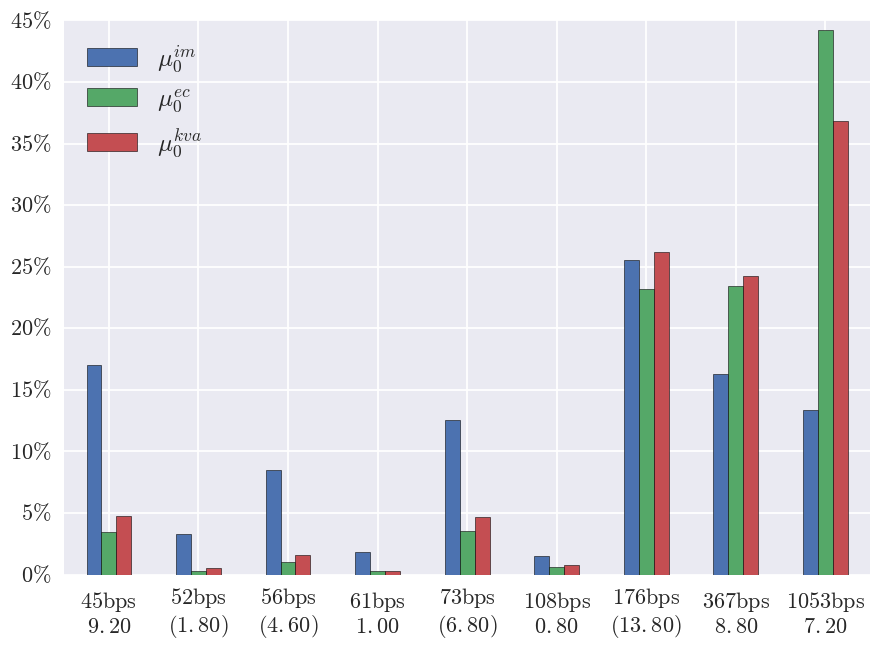

In [22]:
spreads = [176, 45, 367, 1053, 73, 56, 52, 61, 108]
ids_spreads = dict((id_, spread_) for (id_, spread_) in zip(c_ids, spreads))

sorted_bc_ids = sorted(ids_spreads.items(), key=lambda x: x[1])
sorted_bc_ids_spreads = [x[0] for x in sorted_bc_ids]

labels_spreads = map(map_id_label, sorted_bc_ids_spreads)

mu_0 = mu_0.reindex(labels_spreads)

mu_0.plot.bar(rot=0)

formatter_pct = lambda x, pos: r'$%.0f \%%$' % (x * 100)
formatter_pct = FuncFormatter(formatter_pct)

plt.gca().yaxis.set_major_formatter(formatter_pct)

plt.legend(loc='best', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize-2)

plt.show()

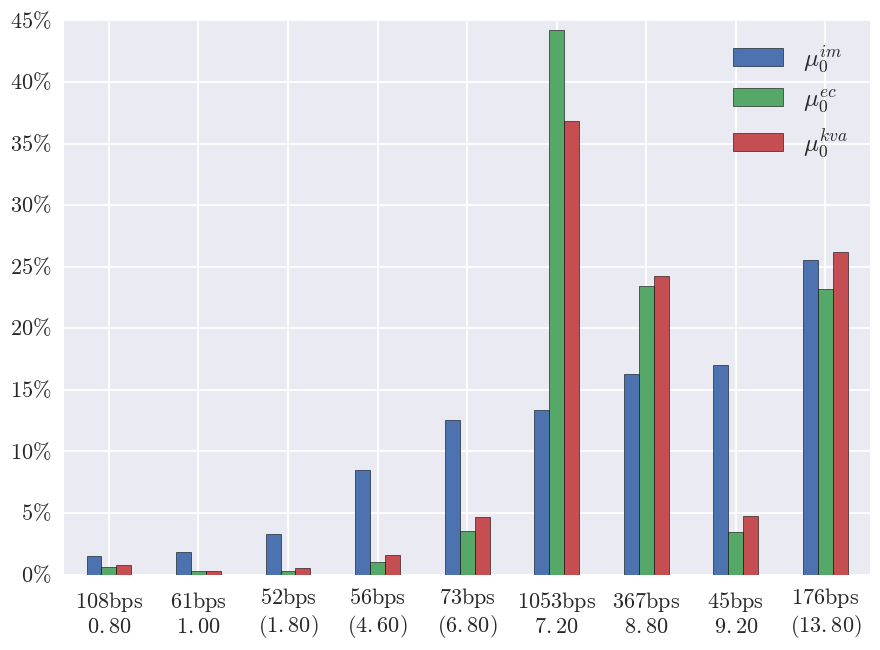

In [23]:
pos = [POSITIONS[kk] for kk in c_ids]
ids_pos = dict((id_, pos_) for (id_, pos_) in zip(c_ids, pos))

sorted_bc_ids = sorted(ids_pos.items(), key=lambda x: abs(x[1]))
sorted_bc_ids_positions = [x[0] for x in sorted_bc_ids]

labels_positions = map(map_id_label, sorted_bc_ids_positions)

mu_0 = mu_0.reindex(labels_positions)

mu_0.plot.bar(rot=0)

formatter_pct = lambda x, pos: r'$%.0f \%%$' % (x * 100)
formatter_pct = FuncFormatter(formatter_pct)

plt.gca().yaxis.set_major_formatter(formatter_pct)

plt.legend(loc='best', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize-2)

plt.show()

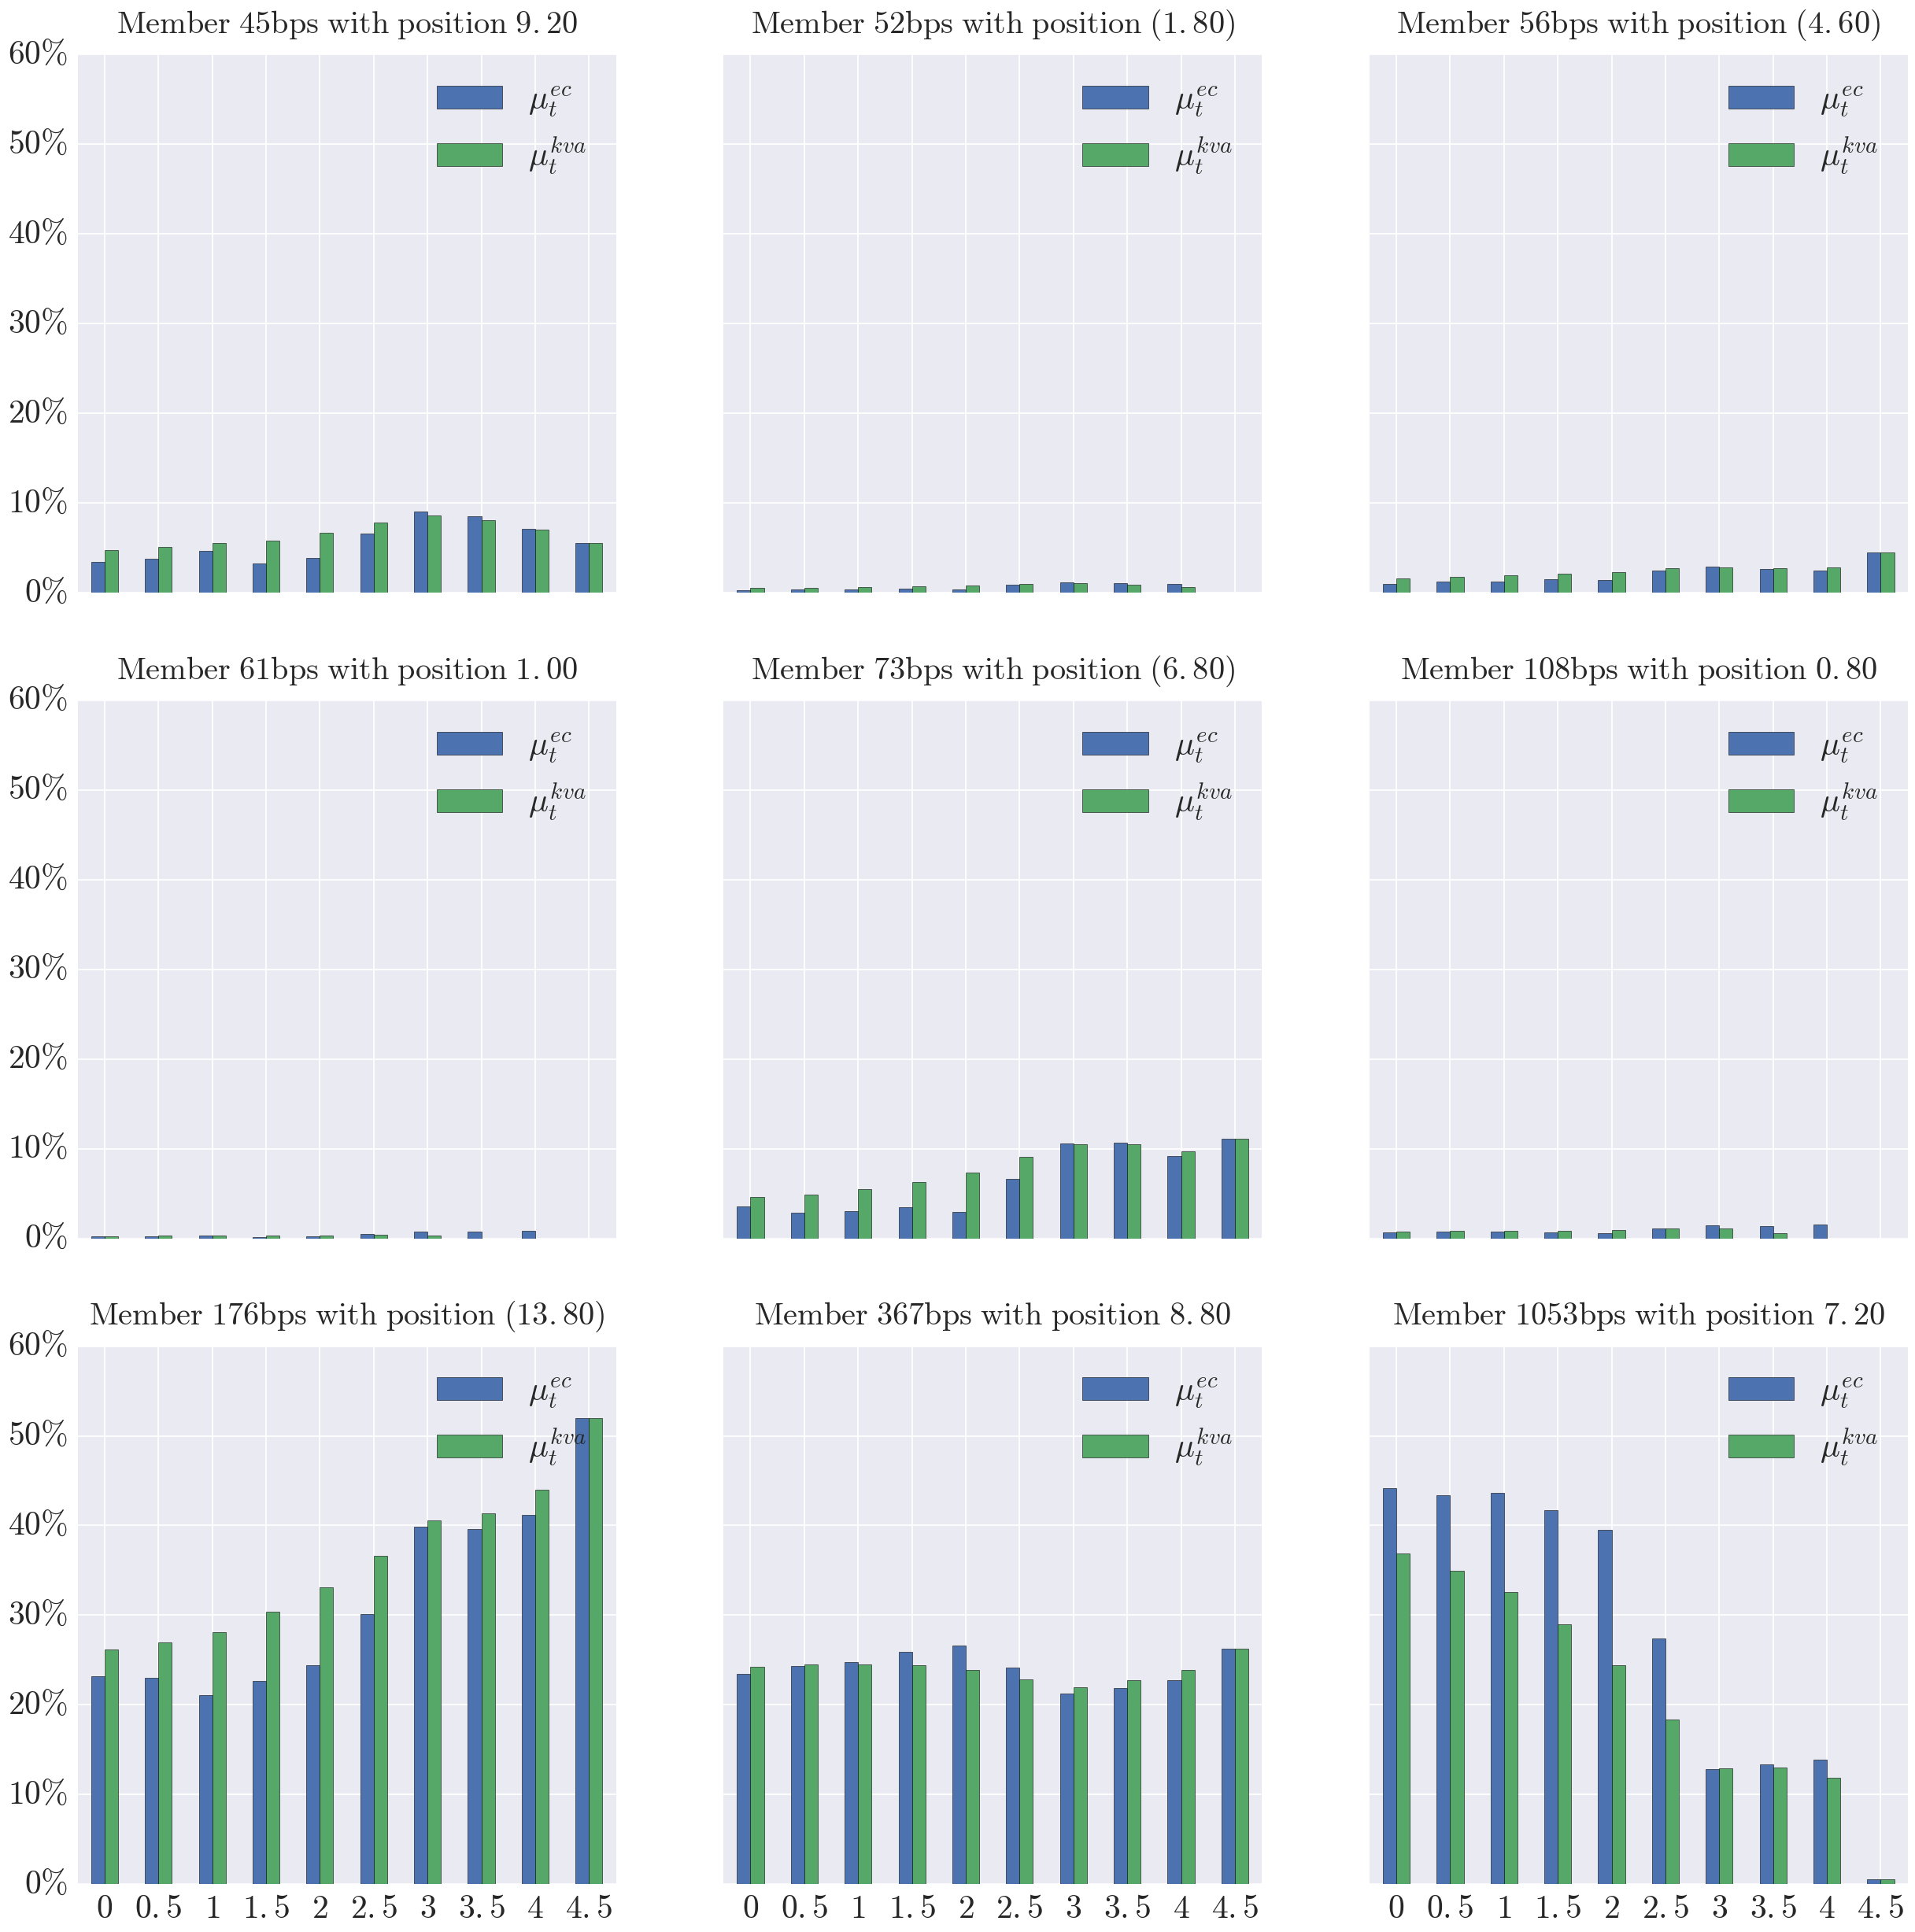

In [24]:
f, ax = plt.subplots(3, 3, figsize=(30, 30), sharex=True, sharey=True)
ax = ax.flatten()

for i, label in enumerate(sorted_bc_ids_spreads):
    label_str = str(label)
    alloc_ec = delta_ec[label_str]
    alloc_kva = delta_kva[label_str]
    
    tmp = {}
    tmp[r'$\mu_t^{ec}$'] = alloc_ec
    tmp[r'$\mu_t^{kva}$'] = alloc_kva
    
    tmp_df = pd.DataFrame(tmp)
    tmp_df.index = tmp_df.index.map(lambda x: formatter_tex_time(x))
    
    tmp_df.plot.bar(ax=ax[i], rot=0)
    
    ax[i].legend(fontsize=labelsize+12)
    
    label = map_id_label(label)
    
    ax[i].yaxis.set_major_formatter(formatter_pct)
    
    title = r'$\rm{Member \,\,}$' + label.replace('\n', r'$\rm{\,\, with \,\, position \,\,}$')
    ax[i].set_title(title, y=1.03, fontsize=titlesize+9)
    ax[i].tick_params(axis='both', which='major', labelsize=labelsize+12)
    
plt.show()